# Factors predicting user adoption

## Task

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period , identify which factors predict future user
adoption .

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import urllib
import requests
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler


## Which users are active users?

In [2]:
#Load Data

#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file = 'takehome_user_engagement.csv'
file_name_path = os.path.join(basepath,  file)
engagement= pd.read_csv(file_name_path)

#Open data
engagement.head(5)

C:\Users\Tiki\Documents\Sprinboard2\Mini Projects\relax_challenge
['.ipynb_checkpoints', 'Feature Importance.png', 'relax_data_science_challenge.pdf', 'takehome_relax.ipynb', 'takehome_users.csv', 'takehome_users2.csv', 'takehome_user_engagement.csv', 'take_home_complete.csv', 'Untitled.ipynb']


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
#time stamp is a date so convert to date time
engagement['time_stamp']= pd.to_datetime(engagement['time_stamp'])
engagement['time_stamp'] = engagement['time_stamp'].dt.floor('d').astype(np.int64)
engagement.pop('visited')
#remove duplicates as it does not count as multiple visits if it happens on the same day
#sort values by users so we can what how many days per user
engagement = engagement.sort_values(['user_id', 'time_stamp']).drop_duplicates() #it doesn't count if it happens 3x in one day


In [5]:
#Create window of every three sequential times a user logged in
a = engagement.groupby('user_id')['time_stamp'].rolling(window=3)

#determine what was the max and min time of for every window call this value b
b = pd.to_timedelta((a.max()- a.min())).dt.days
print (b)


user_id        
1        0          NaN
2        1          NaN
         2          NaN
         3         24.0
         4         26.0
                   ... 
11996    207912     NaN
11997    207913     NaN
11998    207914     NaN
11999    207915     NaN
12000    207916     NaN
Name: time_stamp, Length: 207917, dtype: float64


In [6]:
#If any value b is less than 7  for a user then the user is an adopted user
c = b[b < 8].index.get_level_values('user_id').tolist()

#This only needs to happen once
c= np.unique(np.array(c)).tolist()
print(len(c))

1656


## What factors affect active users 

import chardet
with open(file_name_path2, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

In [99]:
#get user data
new_file = 'takehome_users.csv'
file_name_path2 = os.path.join(basepath, new_file)
df = pd.read_csv(file_name_path2,encoding='ISO-8859-1')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### Cleaning/merging data

In [100]:
#if object id is user's id if user id in adopted listed then they are an adopted user
df['adopted_user']= df['object_id'].isin(c)

#convert dates
df['last_session_creation_time']= pd.to_datetime(df['last_session_creation_time'], unit='s')
df['creation_time']= pd.to_datetime(df['creation_time'])

#extract creation & last session month and year
df['creation_month']= pd.DatetimeIndex(df['creation_time']).month
df['creation_year']= pd.DatetimeIndex(df['creation_time']).year
df['last_session_month']= pd.DatetimeIndex(df['last_session_creation_time']).month
df['last_session_year']= pd.DatetimeIndex(df['last_session_creation_time']).year

df['user_time']= (df['last_session_creation_time']-df['creation_time']).dt.days

#if no last session creation time we have to assume that the last session was the first (At least with regards to use date)
#if not by user id fill with 0
#as those columns and their derivitive are the only ones in null values we fill all nulls with 0
df=df.fillna(0)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted_user                12000 non-null  bool          
 11  creation_month              12000 non-null  int64     

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_month,creation_year,last_session_month,last_session_year,user_time
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,4,2014,4.0,2014.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,11,2013,3.0,2014.0,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,3,2013,3.0,2013.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,5,2013,5.0,2013.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,1,2013,1.0,2013.0,5.0


### Feature manipulation

In [101]:
#back of users
df['email_loc'] = df['email'].str.split(pat="@").str[-1]
df['email_sub_domain'] = df['email_loc'].str.split(pat=".").str[0]
df['email_domain'] = df['email_loc'].str.split(pat=".").str[-1]
df['.de_email'] = df['email_domain']=='de'

#too many email_locs with values count less than 3 so
sub_domain = df.email_sub_domain.value_counts().to_frame()
sub_domain= sub_domain[sub_domain>2].dropna()
sub_domain_list = sub_domain.index.tolist()
df['email_sub_domain'] = np.where(df.email_sub_domain.isin(sub_domain_list), df.email_sub_domain, "NA")

#repeat with user_id


print(df.info())
print(df.nunique())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted_user                12000 non-null  bool          
 11  creation_month              12000 non-null  int64     

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_month,creation_year,last_session_month,last_session_year,user_time,email_loc,email_sub_domain,email_domain,.de_email
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,4,2014,4.0,2014.0,0.0,yahoo.com,yahoo,com,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,11,2013,3.0,2014.0,136.0,gustr.com,gustr,com,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,3,2013,3.0,2013.0,0.0,gustr.com,gustr,com,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,5,2013,5.0,2013.0,1.0,yahoo.com,yahoo,com,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,1,2013,1.0,2013.0,5.0,yahoo.com,yahoo,com,False


In [102]:
new_file2 = 'take_home_complete.csv'
new_file_name_path = os.path.join(basepath, new_file2)
df.to_csv(new_file_name_path, index=False)

## Machine LEarning

In [82]:
#Split Data
y = df.pop('adopted_user')

#object id gives no useful info and both name and email are pretty unique to each user
#(we tried to only take data after the @ in emails and got too many categories

X = df.drop(['object_id','creation_time', 'last_session_creation_time', 'name', 'email', 'email_loc', 'email_domain'],axis = 1)

seed = 17  # so that the result is reproducible and the meaning of life
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = seed)

In [103]:
#Encode categorical variables

#seperate categorical features
features_to_encode = X_train.columns[X_train.dtypes==object].tolist()

#encode categorical feathres
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer(
    (OneHotEncoder(),features_to_encode),remainder = "passthrough")


#Since we are using random forest scaling is not useful here [This is one of the reasons to use it to look at feature importance]

In [104]:
#create random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

rf_classifier = RandomForestClassifier(
                      n_estimators=150,
                      oob_score=True,
                      random_state=seed,
                      max_features='auto')

In [105]:
#train model
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier)
pipe = Pipeline([
    ('col_trans', col_trans),
    ('classifier', rf_classifier)])
pipe.fit(X_train, y_train)

#predict
y_pred = pipe.predict(X_test)



In [106]:
#The below function comes from user DTrimarchi10. I l just like using it
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        


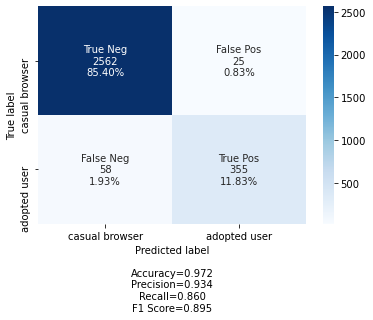

In [107]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['casual browser', 'adopted user']
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [108]:
#good enough!!

In [109]:
from sklearn.metrics import roc_auc_score, roc_curve

#probability predictions (needed for ROC AUC curve)
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)


print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')




Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.9936977680355586


## Feature Importance Random Forest Regression

### Create Feature Importance Tables

In [110]:
ohe = pipe.named_steps['col_trans'].named_transformers_['onehotencoder']
#cc= pipe.named_steps['col_trans'].transformers[-1][-1]
cc= X_train.select_dtypes(['object']).columns
cat_cols= ohe.get_feature_names(input_features=cc)
numerical_cols = X_train.select_dtypes([np.int64,np.float64, 'bool']).columns
feature_names = np.r_[numerical_cols,cat_cols]

In [111]:
#Calculate feature importance train set given the first regression
fimpotance_train = pd.DataFrame(rf_classifier.feature_importances_, columns=['Mean Feature Importance'], index=feature_names)
fimpotance_train 

,Mean Feature Importance
opted_in_to_mailing_list,0.003292
enabled_for_marketing_drip,0.003692
org_id,0.003015
invited_by_user_id,0.003145
creation_month,0.002488
creation_year,0.002695
last_session_month,0.001727
last_session_year,0.003968
user_time,0.002448
.de_email,0.002434


In [112]:
from sklearn.inspection import permutation_importance
#Calculate feature importance for five splits using the train set
result_train = permutation_importance(pipe, X_train, y_train, n_repeats=8, n_jobs=-1, random_state=seed)


In [113]:
#Create data frame of feature importances for the five folds given the train set
feature_names2= X_train.columns
fimpotance_train2 = pd.DataFrame(result_train.importances.T, columns=feature_names2)
fimpotance_train2

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_month,creation_year,last_session_month,last_session_year,user_time,email_sub_domain,.de_email
0,0.010889,0.002000,0.001444,0.010778,0.005889,0.008556,0.005000,0.013222,0.009222,0.201889,0.013333,0.000222
1,0.011667,0.002556,0.000889,0.011222,0.006222,0.007000,0.003667,0.013444,0.009222,0.204667,0.012222,0.000222
2,0.012556,0.001889,0.000889,0.012111,0.006556,0.008556,0.004556,0.012111,0.009667,0.205444,0.011778,0.000333
3,0.012333,0.002222,0.001111,0.010889,0.005778,0.007333,0.003556,0.012556,0.008333,0.198889,0.011778,0.000444
4,0.011111,0.002333,0.001000,0.011667,0.006778,0.007889,0.004333,0.011444,0.008333,0.203444,0.011444,0.000444


In [114]:
from sklearn.inspection import permutation_importance
#Calculate feature importance for five splits using the test set
result_test = permutation_importance(pipe, X_test, y_test, n_repeats=5, n_jobs=-1, random_state=seed)

#Create data frame of feature importances for the five folds given the train set
fimpotance_test2 = pd.DataFrame(result_test.importances.T, columns=feature_names2)
fimpotance_test2

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_month,creation_year,last_session_month,last_session_year,user_time,email_sub_domain,.de_email
0,0.000667,-0.001333,0.000667,0.000333,0.000000,-0.001333,-0.001000,0.001667,0.001000,0.180000,0.000000,-0.000333
1,0.002667,-0.001333,0.000333,-0.000333,0.000000,0.000000,-0.001333,0.001000,0.000667,0.176667,-0.002000,0.000000
2,0.001000,-0.000667,-0.000667,-0.000333,-0.000667,-0.000333,-0.001000,0.001000,0.001333,0.169333,-0.000333,-0.000333
3,0.000000,-0.000667,-0.001000,0.000333,0.000333,0.000000,-0.000333,0.000000,0.001333,0.176333,-0.000667,-0.000333
4,0.001333,-0.000667,0.000333,-0.001000,0.000667,-0.001000,-0.001333,0.000000,0.003333,0.174667,-0.002000,0.000000


### Visualizing Feature Importance

In [115]:
z30 = fimpotance_train.sort_values(by= ['Mean Feature Importance'], ascending= False)
z30=z30.reset_index().rename(columns={"index": "Feature Name"})
z5= z30.sort_values(by= ['Mean Feature Importance'], ascending= False).head(7)
z20= z30.sort_values(by= ['Mean Feature Importance'], ascending= False).tail(15)

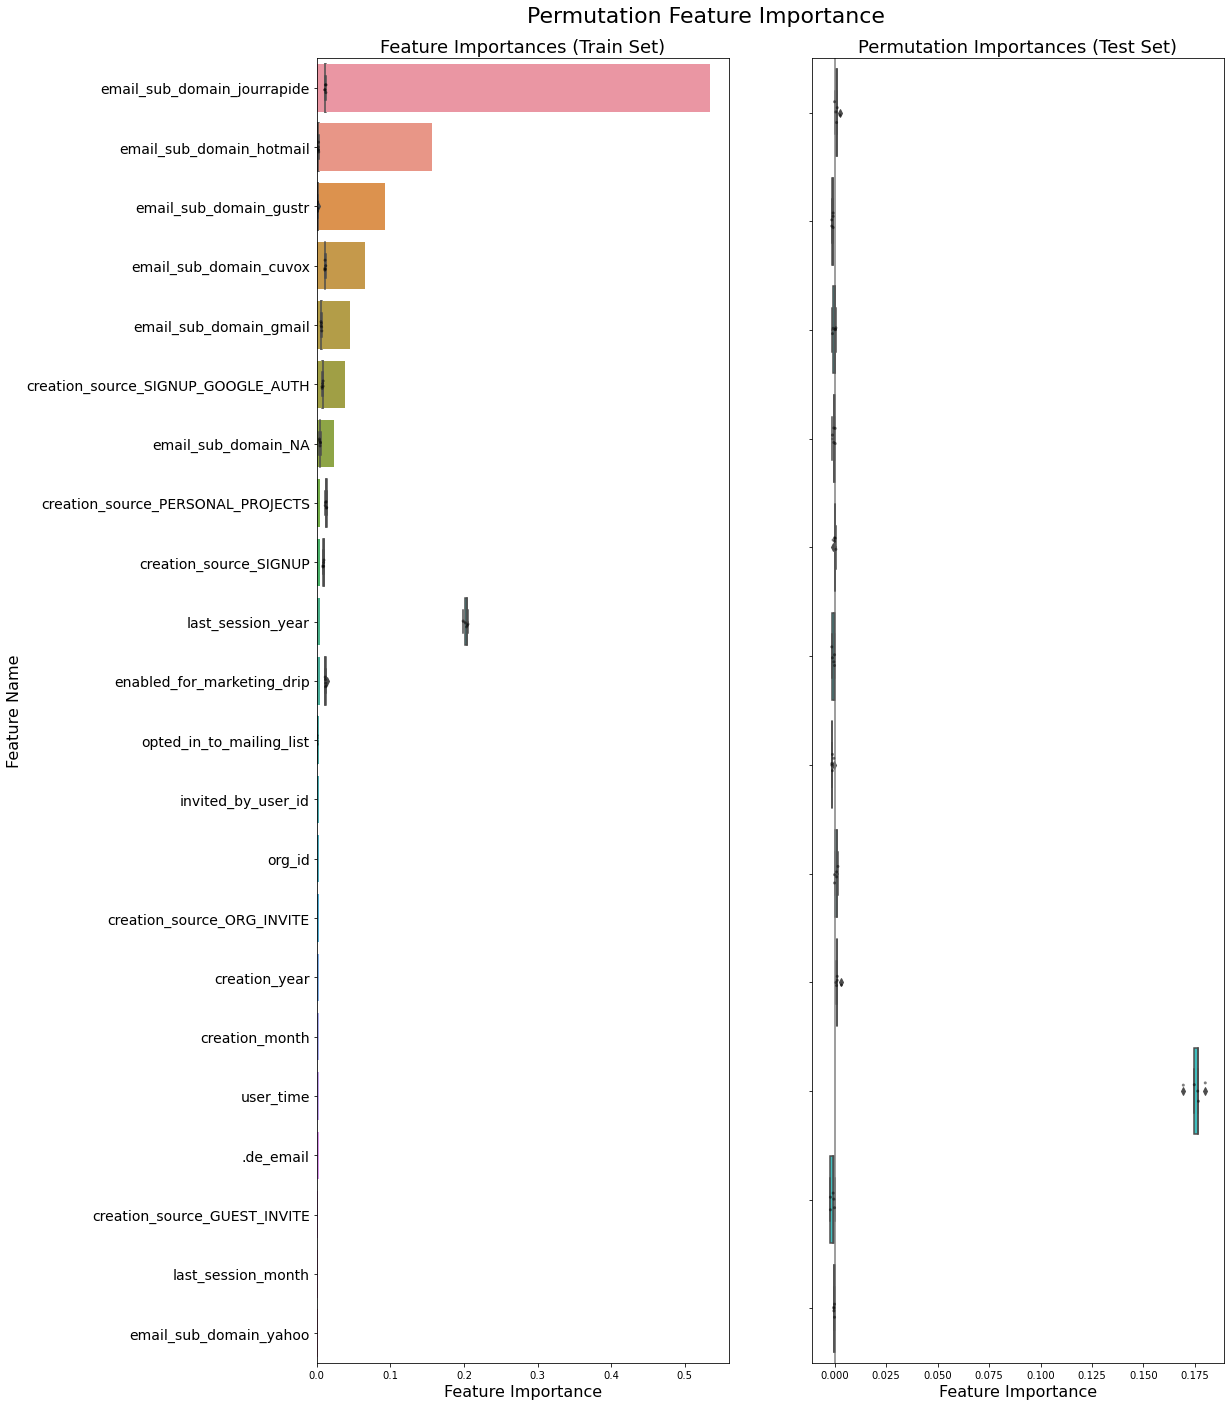

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(18, 24), sharey=True, sharex=True)
fig.suptitle('Permutation Feature Importance', fontsize=22, y=0.91, x= 0.5)
ax = plt.subplot(121)
sns.stripplot(data=fimpotance_train2, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=fimpotance_train2, orient='h', color='cyan', saturation=0.5)

sns.barplot(x='Mean Feature Importance',  y="Feature Name",  data=z30)
plt.title("Feature Importances (Train Set)", fontsize=18)
plt.xlabel('Feature Importance', fontsize=16)
plt.ylabel('Feature Name', fontsize=16)
plt.yticks(fontsize=14)

plt.subplot(122)



#graphing coefficent and importance
#sns.swarmplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.stripplot(data=fimpotance_test2, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=fimpotance_test2, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (Test Set)", fontsize=18)
plt.xlabel('Feature Importance', fontsize=16)
plt.subplots_adjust(left=.2)

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig("Feature Importance")